In [1]:
import hmmlearn
from hmmlearn import base
from HMM import MultiThreadFit
import pickle
import numpy as np
from tqdm import tqdm
import europarl_dataloader as e_dl
from hmm_training import TbXMonitor
import sys

In [2]:
DATASET_PATH = "output/europarl-v7.de-en.de.clean"
TRAIN_STEP_SIZE = 20
THRESHOLD = 4
MODEL_PATH = "output/tss20_th4_nSt200_nIt101.pkl"

In [3]:
print(MODEL_PATH)
lines = e_dl.load_clean_dataset(DATASET_PATH)
testLines = lines[:4096]
trainLines = lines[4096::TRAIN_STEP_SIZE]
del lines

trainWordcount = e_dl.count_words(trainLines)
testWordcount = e_dl.count_words(testLines)
trainAlphabet = e_dl.create_alphabet(trainWordcount, threshold=THRESHOLD)
testAlphabet = e_dl.create_test_alphabet(trainAlphabet, testWordcount)

output/tss20_th4_nSt200_nIt101.pkl


create test alphabet: 100%|██████████| 11866/11866 [00:00<00:00, 857431.50it/s]


In [4]:
# prepare tokens
# lines_X = [[[trainAlphabet[word]] for word in line if len(word)]
#            for line in tqdm(trainLines, desc="trainTokenSet") if
#            len(line) > 1 or (len(line) == 1 and len(line[0]))]
# len_X = [len(line) for line in lines_X]
# X = np.concatenate(lines_X)
# del trainLines  # free space

lines_Y = [[[testAlphabet[word]] for word in line if len(word)]
           for line in tqdm(testLines, desc="testTokenSet") if
           len(line) > 1 or (len(line) == 1 and len(line[0]))]
len_Y = [len(line) for line in lines_Y]
Y = np.concatenate(lines_Y)
del testLines  # free space

testTokenSet: 100%|██████████| 4096/4096 [00:00<00:00, 28631.49it/s]


In [25]:
with open(MODEL_PATH, 'rb') as file:
    model = pickle.load(file)
""" :type model: MultiThreadFit"""

model.transmat_orig = model.transmat_.copy()
model.startprob_orig = model.startprob_.copy()
model.emissionprob_orig = model.emissionprob_.copy()

In [6]:
print(model.score(Y, len_Y))

Score: 100%|██████████| 4090/4090 [01:05<00:00, 62.72it/s]


-530292.0261611923


In [26]:
print(f"Max Thresholds:\ntransmat_ {model.transmat_orig.max(axis=0).min()}\nemissionprob_ {model.emissionprob_orig.max(axis=0).min()}")

Max Thresholds:
transmat_ 0.011764182185361695
emissionprob_ 6.39856825391699e-05


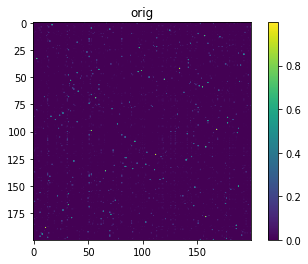

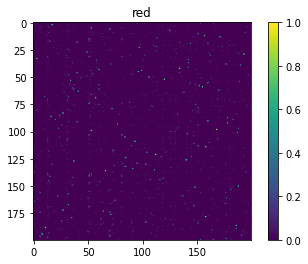

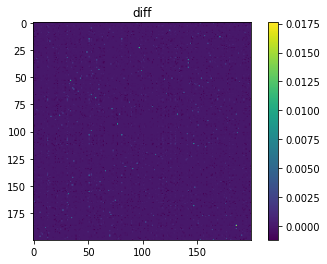

In [27]:
transmat_th = model.transmat_orig.max(axis=0).min() * 0.1
model.transmat_ = model.transmat_orig.copy()
model.transmat_[model.transmat_orig < transmat_th] = 0
# model.transmat_ = model.transmat_ ** 0.5
for i in range(model.transmat_.shape[0]):
    model.transmat_[i,:] /= model.transmat_[i,:].sum()

import matplotlib.pyplot as plt
plt.title("orig")
plt.imshow(model.transmat_orig)
plt.colorbar()
plt.show()

plt.title("red")
plt.imshow(model.transmat_)
plt.colorbar()
plt.show()

plt.title("diff")
plt.imshow(model.transmat_- model.transmat_orig)
plt.colorbar()
plt.show()
        

In [14]:
startprob_th = model.startprob_orig.max() * 0.1
model.startprob_ = model.startprob_orig.copy()
model.startprob_[model.startprob_orig < startprob_th] = 0
# model.startprob_ = model.startprob_** 0.5
model.startprob_ /= model.startprob_.sum()

In [28]:
emissionprob_th = model.emissionprob_orig.max(axis=0).min() * 0.1
model.emissionprob_ = model.emissionprob_orig.copy()
model.emissionprob_[model.emissionprob_orig < emissionprob_th] = 0
# model.emissionprob_ = model.emissionprob_ ** 0.5
for i in range(model.emissionprob_.shape[0]):
    model.emissionprob_[i,:] /= model.emissionprob_[i,:].sum()

In [29]:
print(model.score(Y, len_Y))

Score:  44%|████▍     | 1808/4090 [00:12<00:17, 129.32it/s]/usr/local/lib/python3.7/site-packages/hmmlearn/utils.py:86: RuntimeWarning: divide by zero encountered in log
  return np.log(a)
Score: 100%|██████████| 4090/4090 [00:29<00:00, 139.65it/s]


-inf
